## Load

In [1]:
import numpy as np
import pandas as pd
import scipy.io
from numpy import cov
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
import shutil
from PIL import Image

In [2]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        meta = meta.head(1) # multisession, only keep one metadata
    return meta


def load_dataset(root_path, meta, nori=30, nisi=1, nframe_trial=143):
    nset = len(meta.index)
    ncell = []
    dir_name = root_path + 'mat/'

    dfof_ad = np.empty([0,nori]); dfof_tg = np.empty([0,nori])
    dfof_ad_std = np.empty([0,nori]); dfof_tg_std = np.empty([0,nori])
    trace = np.empty([0,nori,nframe_trial])
    # vis_ad = np.empty([0,nori]); 

    for iset in np.arange(nset):
        dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

        dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
        ncell.append(dfof['dfof_ad'].shape[0])    
#         trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
#         cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'vis_driven' + '.mat'))
#         vis_ad = np.concatenate((vis_ad, cell_prop['sig_vis_ad']), axis=0)

        dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
        dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
        dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
        dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)

#         trace_flat = np.empty([ncell[iset],nori,nframe_trial]);
#         for icell in np.arange(ncell[iset]):
#             for iori in np.arange(nori):
#                 trace_flat[icell][iori][:] = trace_align['trace_avg'][icell][iori].flatten()
#         trace = np.vstack((trace,trace_flat))

#     print(ncell, dfof_ad.shape, dfof_tg.shape, trace.shape)
    return ncell, dfof_ad, dfof_tg, trace #vis_ad


def construct_cell_metadata():
    meta['ncell'] = ncell
    # meta
    mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
    area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
    meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
    return meta_cell

## Adp mag

In [32]:
def calc_adp_mag(dfof_tg, dfof_ad):
    adp_mag = dfof_tg / dfof_ad - 1
    # adp_mag = adp_mag * vis_ad; adp_mag[adp_mag == 0] = np.nan
    return adp_mag
    
def df_adp_mag(adp_mag):
    mag = adp_mag.flatten('F')
    ad = dfof_ad.flatten('F')
    tg = dfof_tg.flatten('F')
    cell_num = [np.arange(adp_mag.shape[0])] * adp_mag.shape[1]
    cell_num = np.concatenate(cell_num)
    stim = [np.arange(nori)] * adp_mag.shape[0]
    stim_flat = np.sort([item for sublist in stim for item in sublist])
    df = pd.DataFrame({'cell':cell_num ,'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
    return stim_flat, mag, ad, df


def threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=20):
    df_th = df.copy()
    df_th.loc[df_th[(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan # not threshold by abs, bc 1-tail ttest originally
    df_th.loc[df_th[np.abs(df.mag) > adp_threshold].index.to_numpy(),'mag'] = np.nan # bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag
    
    mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
    mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
    mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
    mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
    return df_th, mag_mean, mag_median, mag_std, mag_sem


def sort_img_by_adp(df_th):
    stim_order_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().sort_values('mag').index.values
    stim_order_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().sort_values('mag').index.values
    adp_mean = np.sort(mag_mean.copy())
    adp_median = np.sort(mag_median.copy())
    return stim_order_mean, stim_order_median, adp_mean, adp_median

## Sort adp vs shuffle

In [33]:
def shuffle_adp_by_stim(adp_mag, dfof_threshold=0.00025, adp_threshold=20):
    adp_shuffle = adp_mag.copy()
#     print(adp_mag.shape) # ncell x nstim. should shuffle along rows (keep cell order, permute stim order)
    [np.random.shuffle(x) for x in adp_shuffle]; # shuffle every row
    return adp_shuffle

In [34]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
nori=30; nisi=1; nframe_trial=143
ncell, dfof_ad, dfof_tg, trace = load_dataset(root_path, meta, nori=30, nisi=1, nframe_trial=143)
meta_cell = construct_cell_metadata()

adp_mag = calc_adp_mag(dfof_tg, dfof_ad)
stim_flat, mag, ad, df = df_adp_mag(adp_mag)
df_th, mag_mean, mag_median, mag_std, mag_sem = threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=20)
stim_order_mean, stim_order_median, adp_mean, adp_median = sort_img_by_adp(df_th)

adp_mag = calc_adp_mag(dfof_tg, dfof_ad)
adp_shuffle = shuffle_adp_by_stim(adp_mag, dfof_threshold=0.00025, adp_threshold=20)
_, _, _, df_shuffle = df_adp_mag(adp_shuffle)
df_th_shuffle, mag_mean_shuffle, mag_median_shuffle, mag_std_shuffle, mag_sem_shuffle = threshold_adp_mag(df_shuffle, 
                                                                                  dfof_threshold=0.00025, adp_threshold=20)
stim_order_mean_shuffle, stim_order_median_shuffle, adp_mean_shuffle, adp_median_shuffle = sort_img_by_adp(df_th_shuffle)

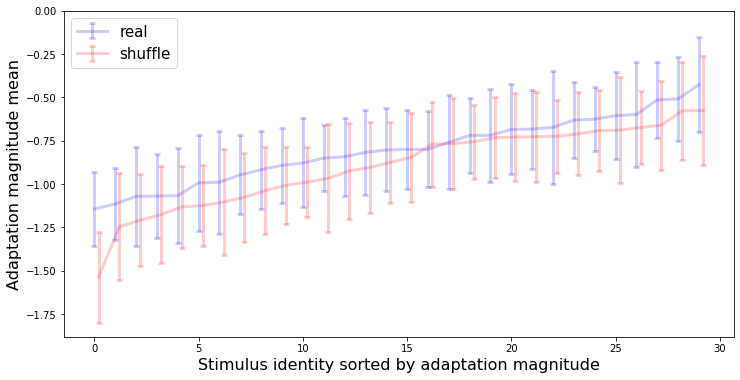

In [35]:
plt.figure(figsize=(12,6))

plt.errorbar(np.arange(nori), mag_mean[stim_order_mean], yerr=mag_sem[stim_order_mean], zorder=1, 
             color='blue', linewidth=3, capsize=3, capthick=3, alpha=0.2);
plt.errorbar(np.arange(nori)+0.2, mag_mean_shuffle[stim_order_mean_shuffle], 
             yerr=mag_sem_shuffle[stim_order_mean_shuffle], zorder=2, 
             color='red', linewidth=3, capsize=3, capthick=3, alpha=0.2);

plt.legend(['real', 'shuffle'], fontsize=15)
plt.ylabel('Adaptation magnitude mean', fontsize=16);
plt.xlabel('Stimulus identity sorted by adaptation magnitude', fontsize=16);
plt.gca().set_ylim(top=0);

## adp by stim
single cell - fit line for adp stim sorted, real data vs shuffle

In [ ]:
# _, _, _, df_shuffle = df_adp_mag(adp_shuffle)
# df_th_shuffle, mag_mean_shuffle, mag_median_shuffle, mag_std_shuffle, mag_sem_shuffle = threshold_adp_mag(df_shuffle, 
#                                                                                   dfof_threshold=0.00025, adp_threshold=20)
stim_order_mean_shuffle, stim_order_median_shuffle, adp_mean_shuffle, adp_median_shuffle = sort_img_by_adp(df_th_shuffle)

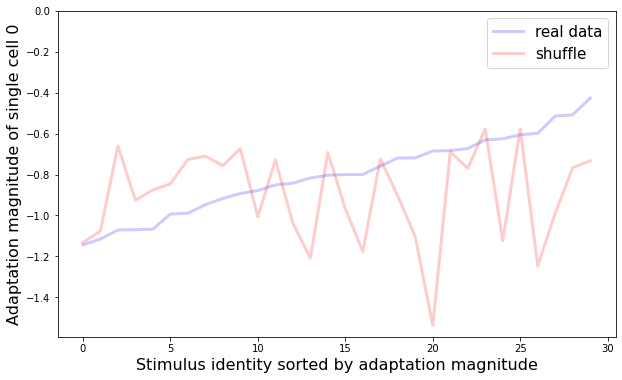

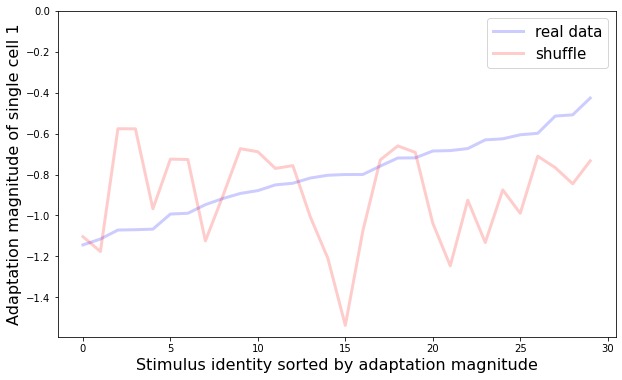

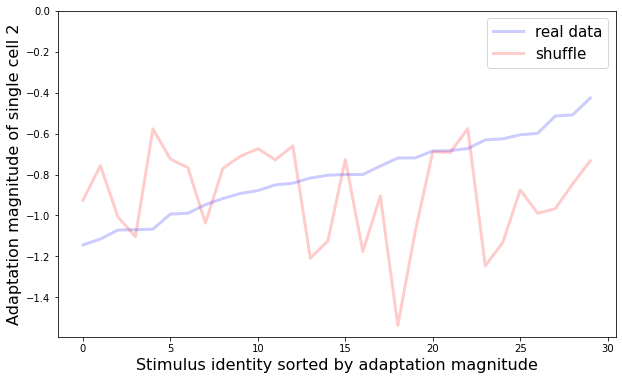

In [61]:
for icell in np.arange(3): #ncell[0]
    df_cell = df_th[df_th.cell == icell]
    stim_order_mean, stim_order_median, adp_mean, adp_median = sort_img_by_adp(df_cell)
    df_cell_shuffle = df_th_shuffle[df_th_shuffle.cell == icell]
    stim_order_mean_shuffle, stim_order_median_shuffle, adp_mean_shuffle, adp_median_shuffle = sort_img_by_adp(df_cell_shuffle)

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(nori), adp_mean, color='blue', linewidth=3, alpha=0.2);
    plt.plot(np.arange(nori), mag_mean_shuffle[stim_order_mean_shuffle], color='red', linewidth=3, alpha=0.2);

    plt.legend(['real data', 'shuffle'], fontsize=15)
    plt.ylabel(f'Adaptation magnitude of single cell {icell}', fontsize=16);
    plt.xlabel('Stimulus identity sorted by adaptation magnitude', fontsize=16);
    plt.gca().set_ylim(top=0);
    # plt.savefig(root_path + f'plot/bunnytop adp sort/adp_sort_single_cell_{icell}.png')
    # plt.close()


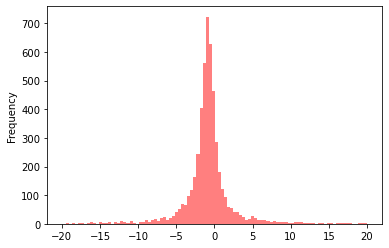

In [ ]:
df_th_shuffle.mag.plot(kind='hist', bins=100, color='red', alpha=0.5, zorder=3, label='shuffle');

## Session 1 vs 3

In [86]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num=2)
nori=30; nisi=1; nframe_trial=143
ncell, dfof_ad, dfof_tg, trace = load_dataset(root_path, meta, nori=30, nisi=1, nframe_trial=143)
meta_cell = construct_cell_metadata()
adp_mag = calc_adp_mag(dfof_tg, dfof_ad)
stim_flat, mag, ad, df = df_adp_mag(adp_mag)
# stim_flat, mag, ad, df = calculate_adp_mag()
df_th, mag_mean_002, mag_median_002, mag_std, mag_sem = threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=20)
stim_order_mean_002, stim_order_median_002, adp_mean_002, adp_median_002 = sort_img_by_adp(df_th)

meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num=4)
nori=30; nisi=1; nframe_trial=143
ncell, dfof_ad, dfof_tg, trace = load_dataset(root_path, meta, nori=30, nisi=1, nframe_trial=143)
meta_cell = construct_cell_metadata()
adp_mag = calc_adp_mag(dfof_tg, dfof_ad)
stim_flat, mag, ad, df = df_adp_mag(adp_mag)
# stim_flat, mag, ad, df = calculate_adp_mag()
df_th, mag_mean_004, mag_median_004, mag_std, mag_sem = threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=20)
stim_order_mean_004, stim_order_median_004, adp_mean_004, adp_median_004 = sort_img_by_adp(df_th)

(324, 30)
(324, 30)


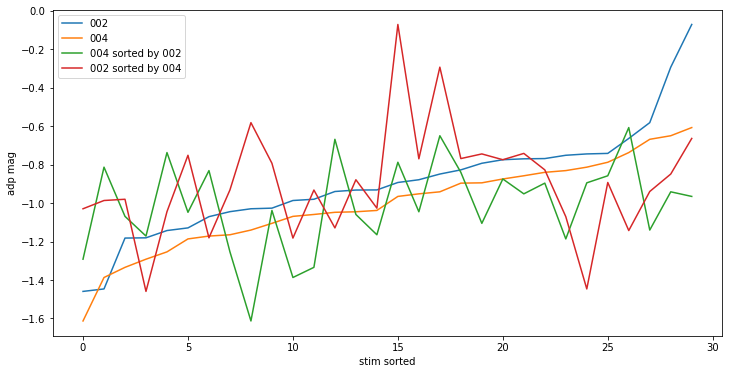

In [72]:
plt.figure(figsize=(12,6))
plt.plot(mag_mean_002[stim_order_mean_002], label='002')
plt.plot(mag_mean_004[stim_order_mean_004], label='004')
plt.plot(mag_mean_004[stim_order_mean_002], label='004 sorted by 002')
plt.plot(mag_mean_002[stim_order_mean_004], label='002 sorted by 004')
plt.xlabel('stim sorted')
plt.ylabel('adp mag')
plt.legend();

(3, 3, 1, 1)

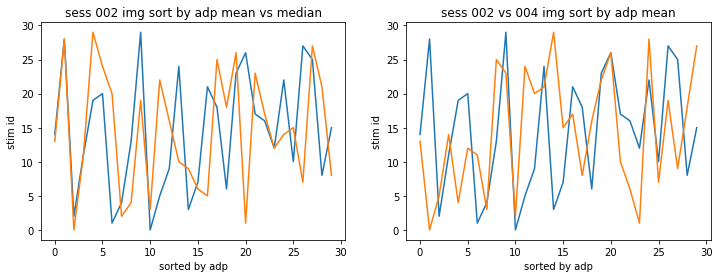

In [96]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(nori),stim_order_mean_002)
plt.plot(np.arange(nori),stim_order_median_002)
plt.title('sess 002 img sort by adp mean vs median');
plt.xlabel('sorted by adp')
plt.ylabel('stim id')

plt.subplot(122)
plt.plot(np.arange(nori),stim_order_mean_002)
plt.plot(np.arange(nori),stim_order_mean_004)
plt.title('sess 002 vs 004 img sort by adp mean');
plt.xlabel('sorted by adp')
plt.ylabel('stim id')

(sum(stim_order_mean_002 == stim_order_median_002), sum(stim_order_mean_004 == stim_order_median_004), 
sum(stim_order_mean_002 == stim_order_mean_004), sum(stim_order_median_002 == stim_order_median_004))

## Half 1 vs 2

In [222]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num=2)
meta.date = '211222_sideA_caiman'
nori=30; nisi=1; nframe_trial=143
ncell, dfof_ad, dfof_tg, trace = load_dataset(root_path, meta, nori=30, nisi=1, nframe_trial=143)
meta_cell = construct_cell_metadata()
adp_mag = calc_adp_mag(dfof_tg, dfof_ad)
stim_flat, mag, ad, df = df_adp_mag(adp_mag)
# adp_abs_median = df.mag.abs().median()
df_th, mag_mean_sideA, mag_median_sideA, mag_std, mag_sem = threshold_adp_mag(df, dfof_threshold=0.00025, 
                                                                              adp_threshold=20)
stim_order_mean_sideA, stim_order_median_sideA, adp_mean_sideA, adp_median_sideA = sort_img_by_adp(df_th)

root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num=2)
meta.date = '211222_sideB_caiman'
nori=30; nisi=1; nframe_trial=143
ncell, dfof_ad, dfof_tg, trace = load_dataset(root_path, meta, nori=30, nisi=1, nframe_trial=143)
meta_cell = construct_cell_metadata()
adp_mag = calc_adp_mag(dfof_tg, dfof_ad)
stim_flat, mag, ad, df = df_adp_mag(adp_mag)
# adp_abs_median = df.mag.abs().median()
df_th, mag_mean_sideB, mag_median_sideB, mag_std, mag_sem = threshold_adp_mag(df, dfof_threshold=0.00025, 
                                                                              adp_threshold=20)
stim_order_mean_sideB, stim_order_median_sideB, adp_mean_sideB, adp_median_sideB = sort_img_by_adp(df_th)

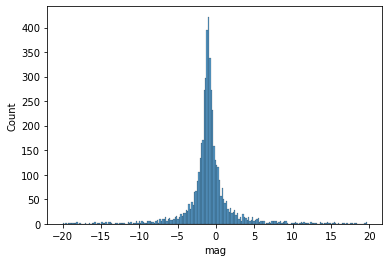

In [223]:
sns.histplot(data=df_th, x='mag');

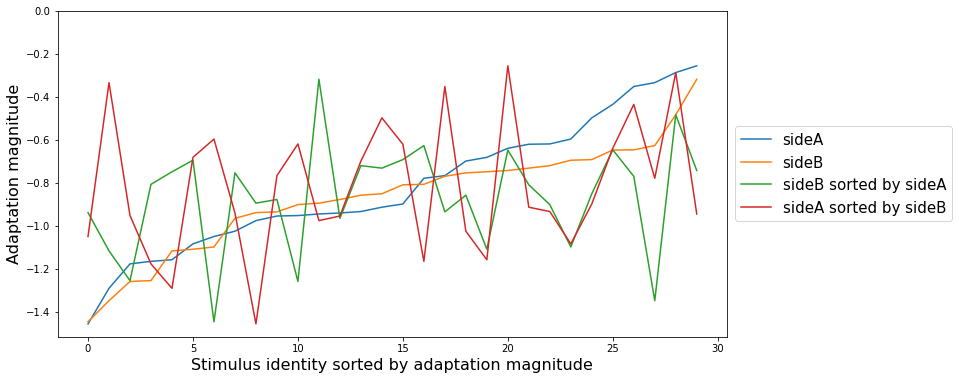

In [226]:
plt.figure(figsize=(12,6))
plt.plot(mag_mean_sideA[stim_order_mean_sideA], label='sideA')
plt.plot(mag_mean_sideB[stim_order_mean_sideB], label='sideB')
plt.plot(mag_mean_sideB[stim_order_mean_sideA], label='sideB sorted by sideA')
plt.plot(mag_mean_sideA[stim_order_mean_sideB], label='sideA sorted by sideB')
plt.xlabel('Stimulus identity sorted by adaptation magnitude', fontsize=16)
plt.ylabel('Adaptation magnitude', fontsize=16)
plt.legend(fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5));
plt.gca().set_ylim(top=0);

In [227]:
corr_pearson, p_pearson = stats.pearsonr(mag_mean_sideA, mag_mean_sideB)
corr_spearman, _ = stats.spearmanr(mag_mean_sideA, mag_mean_sideB) # spearman p is only probably reasonable for datasets larger than 500 or so

corr_pearson_shuffle_seq = []
p_pearson_shuffle_seq = []
corr_spearman_shuffle_seq = []
for i in np.arange(10000): # run with 10000 iter to get reasonable runtime

    mag_mean_sideA_shuffle = mag_mean_sideA.copy()
    np.random.shuffle(mag_mean_sideA_shuffle)
    mag_mean_sideB_shuffle = mag_mean_sideB.copy()
    np.random.shuffle(mag_mean_sideB_shuffle)

    corr_pearson_shuffle, p_pearson_shuffle = stats.pearsonr(mag_mean_sideA_shuffle, mag_mean_sideB_shuffle)
    corr_spearman_shuffle, _ = stats.spearmanr(mag_mean_sideA_shuffle, mag_mean_sideB_shuffle)
    
    corr_pearson_shuffle_seq = np.append(corr_pearson_shuffle_seq, corr_pearson_shuffle)
    p_pearson_shuffle_seq = np.append(p_pearson_shuffle_seq, p_pearson_shuffle)
    corr_spearman_shuffle_seq = np.append(corr_spearman_shuffle_seq, corr_spearman_shuffle)
    
corr_pearson_shuffle = np.mean(corr_pearson_shuffle_seq)
p_pearson_shuffle = np.mean(p_pearson_shuffle_seq)
corr_spearman_shuffle = np.mean(corr_spearman_shuffle_seq)

print(corr_pearson, corr_spearman)
print(corr_pearson_shuffle, corr_spearman_shuffle)

print(p_pearson, p_pearson_shuffle) 
# probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme 
# as the one computed from these datasets

0.17993357409058092 0.23692992213570632
-0.0004532267803354239 -0.0013861624026696325
0.3413728576224463 0.49836536028418277


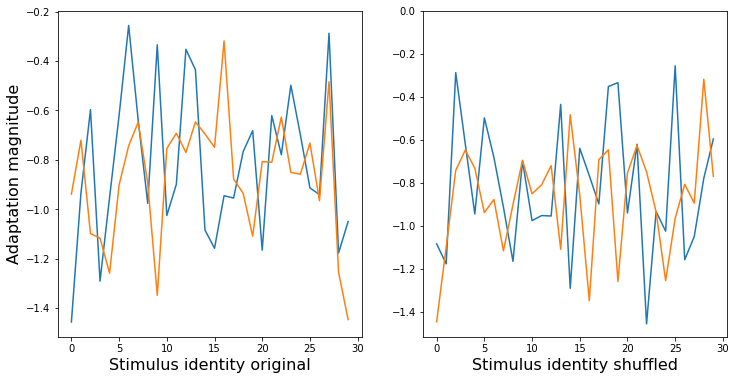

In [231]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(mag_mean_sideA, label='sideA, original order')
plt.plot(mag_mean_sideB, label='sideB, original order')
plt.xlabel('Stimulus identity original', fontsize=16)
plt.ylabel('Adaptation magnitude', fontsize=16)

plt.subplot(122)
plt.plot(mag_mean_sideA_shuffle, label='sideA shuffled')
plt.plot(mag_mean_sideB_shuffle, label='sideB shuffled')
plt.xlabel('Stimulus identity shuffled', fontsize=16)

plt.gca().set_ylim(top=0);

(0, 3, 1, 1)

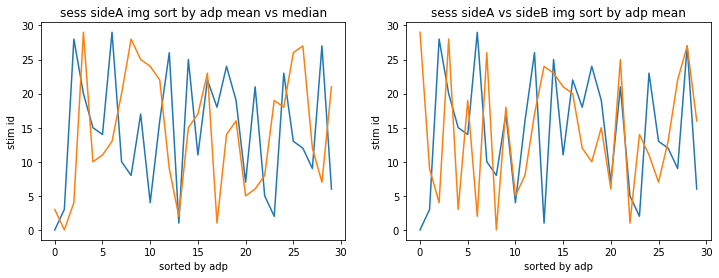

In [229]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(nori),stim_order_mean_sideA)
plt.plot(np.arange(nori),stim_order_median_sideA)
plt.title('sess sideA img sort by adp mean vs median');
plt.xlabel('sorted by adp')
plt.ylabel('stim id')

plt.subplot(122)
plt.plot(np.arange(nori),stim_order_mean_sideA)
plt.plot(np.arange(nori),stim_order_mean_sideB)
plt.title('sess sideA vs sideB img sort by adp mean');
plt.xlabel('sorted by adp')
plt.ylabel('stim id')

(sum(stim_order_mean_sideA == stim_order_median_sideA), sum(stim_order_mean_sideB == stim_order_median_sideB), 
sum(stim_order_mean_sideA == stim_order_mean_sideB), sum(stim_order_median_sideA == stim_order_median_sideB))